# Financial News Sentiment Analysis
In this notebook, we will perform sentiment analysis on financial news. The outputs will be classified as positive, negative, or neutral.

In [31]:
# Import all required libraries
import pandas as pd
import numpy as np
# Explicitly import sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  # Make sure this line is present
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import re
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: Run this section only once to download NLTK datasets
# After running once successfully, you can comment out the section below
"""
# Set the directory for NLTK data
nltk_data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Configure NLTK data directory
nltk.data.path.insert(0, nltk_data_dir)

# Download required NLTK datasets
print("Downloading NLTK datasets...")
for dataset in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    print(f"Downloading {dataset}...")
    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)
    print(f"{dataset} downloaded.")

# Verify downloaded datasets
print("\nVerifying NLTK datasets...")
try:
    # Test dataset usage
    word_tokenize("Test sentence")
    stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize("testing")
    print("All NLTK datasets successfully loaded and tested.")
except LookupError as e:
    print(f"Error: {str(e)}")
    print("An error occurred while loading NLTK datasets.")
"""

'\n# Set the directory for NLTK data\nnltk_data_dir = os.path.join(os.path.dirname(os.path.abspath(\'__file__\')), \'nltk_data\')\nif not os.path.exists(nltk_data_dir):\n    os.makedirs(nltk_data_dir)\n\n# Configure NLTK data directory\nnltk.data.path.insert(0, nltk_data_dir)\n\n# Download required NLTK datasets\nprint("Downloading NLTK datasets...")\nfor dataset in [\'punkt\', \'stopwords\', \'wordnet\', \'omw-1.4\']:\n    print(f"Downloading {dataset}...")\n    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)\n    print(f"{dataset} downloaded.")\n\n# Verify downloaded datasets\nprint("\nVerifying NLTK datasets...")\ntry:\n    # Test dataset usage\n    word_tokenize("Test sentence")\n    stopwords.words(\'english\')\n    lemmatizer = WordNetLemmatizer()\n    lemmatizer.lemmatize("testing")\n    print("All NLTK datasets successfully loaded and tested.")\nexcept LookupError as e:\n    print(f"Error: {str(e)}")\n    print("An error occurred while loading NLTK datasets.")\n'

## Loading and Exploring the Dataset

In [32]:
# Load the dataset
df = pd.read_csv('../data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

# Create label encoder for sentiment values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

# Store the mapping for future reference
sentiment_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nSentiment Label Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment} -> {code}")

# Display first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())

# General information about the dataset
print("\nDataset information:")
print(df.info())

# Distribution of sentiment classes
print("\nDistribution of sentiment classes:")
print(df['sentiment'].value_counts())


Sentiment Label Mapping:
Sentiment -> 0
negative -> 1
neutral -> 2
positive -> 3

First 5 rows of the dataset:
                                                text  sentiment  \
0                                           Sentence  Sentiment   
1  The GeoSolutions technology will leverage Bene...   positive   
2  $ESI on lows, down $1.50 to $2.50 BK a real po...   negative   
3  For the last quarter of 2010 , Componenta 's n...   positive   
4  According to the Finnish-Russian Chamber of Co...    neutral   

   sentiment_encoded  
0                  0  
1                  3  
2                  1  
3                  3  
4                  2  

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5843 entries, 0 to 5842
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               5843 non-null   object
 1   sentiment          5843 non-null   object
 2   sentiment_encoded  5843 no

## Text Preprocessing
We will clean and process the text data:
1. Convert to lowercase
2. Remove punctuation
3. Remove stop words
4. Apply lemmatization

In [33]:
# Enhanced text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove stock symbols (e.g., $AAPL, $GOOG)
    text = re.sub(r'\$\w+', '', text)
    
    # Remove numbers with % (percentage)
    text = re.sub(r'\d+%', '', text)
    
    # Remove currency symbols and amounts (e.g., $123.45, €100, £50)
    text = re.sub(r'[$€£¥]\d+(?:\.\d{2})?|\d+(?:\.\d{2})?[$€£¥]', '', text)
    
    # Remove special characters and numbers
    # Keep alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    # Add custom financial stop words
    custom_stop_words = {
        'reuters', 'bloomberg', 'cnbc', 'wsj', 'financial', 'times',
        'reported', 'says', 'said', 'according', 'quarter', 'year',
        'month', 'week', 'day', 'today', 'yesterday', 'tomorrow'
    }
    stop_words.update(custom_stop_words)
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization with pos tagging for better accuracy
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]  # First try as verb
    tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]  # Then as noun
    
    # Remove short words (length < 3)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Preprocess texts in the dataset
df['processed_text'] = df['text'].apply(preprocess_text)

# Display examples of processed texts with original for comparison
print("Examples of processed texts:")
comparison_df = pd.DataFrame({
    'Original Text': df['text'],
    'Processed Text': df['processed_text']
})
print(comparison_df.head().to_string())

Examples of processed texts:
                                                                                                                                                                                                                Original Text                                                                                                                                                                       Processed Text
0                                                                                                                                                                                                                    Sentence                                                                                                                                                                             sentence
1  The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant mult

## Model Comparison
We will compare different models for sentiment analysis:
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Machine (SVM)
4. Naive Bayes
5. XGBoost

Each model will be evaluated using:
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix


Training Logistic Regression...



Training Logistic Regression...


c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Training Logistic Regression...


c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:
Accuracy: 0.7015

Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.16      0.23       169
     neutral       0.71      0.88      0.79       648
    positive       0.74      0.62      0.68       352

    accuracy                           0.70      1169
   macro avg       0.63      0.56      0.57      1169
weighted avg       0.68      0.70      0.67      1169


Confusion Matrix:
[[ 27 111  31]
 [ 29 573  46]
 [  5 127 220]]

Training Random Forest...

Random Forest Results:
Accuracy: 0.6544

Classification Report:
              precision    recall  f1-score   support

    negative       0.20      0.14      0.16       169
     neutral       0.69      0.81      0.74       648
    positive       0.74      0.62      0.68       352

    accuracy                           0.65      1169
   macro avg       0.54      0.52      0.53      1169
weighted avg       0.63      0.65      0.64      1169


Confusion


Training Logistic Regression...


c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:
Accuracy: 0.7015

Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.16      0.23       169
     neutral       0.71      0.88      0.79       648
    positive       0.74      0.62      0.68       352

    accuracy                           0.70      1169
   macro avg       0.63      0.56      0.57      1169
weighted avg       0.68      0.70      0.67      1169


Confusion Matrix:
[[ 27 111  31]
 [ 29 573  46]
 [  5 127 220]]

Training Random Forest...

Random Forest Results:
Accuracy: 0.6544

Classification Report:
              precision    recall  f1-score   support

    negative       0.20      0.14      0.16       169
     neutral       0.69      0.81      0.74       648
    positive       0.74      0.62      0.68       352

    accuracy                           0.65      1169
   macro avg       0.54      0.52      0.53      1169
weighted avg       0.63      0.65      0.64      1169


Confusion

c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\xgboost\training.py:199: UserWarning: [19:17:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training Logistic Regression...


c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Results:
Accuracy: 0.7015

Classification Report:
              precision    recall  f1-score   support

    negative       0.44      0.16      0.23       169
     neutral       0.71      0.88      0.79       648
    positive       0.74      0.62      0.68       352

    accuracy                           0.70      1169
   macro avg       0.63      0.56      0.57      1169
weighted avg       0.68      0.70      0.67      1169


Confusion Matrix:
[[ 27 111  31]
 [ 29 573  46]
 [  5 127 220]]

Training Random Forest...

Random Forest Results:
Accuracy: 0.6544

Classification Report:
              precision    recall  f1-score   support

    negative       0.20      0.14      0.16       169
     neutral       0.69      0.81      0.74       648
    positive       0.74      0.62      0.68       352

    accuracy                           0.65      1169
   macro avg       0.54      0.52      0.53      1169
weighted avg       0.63      0.65      0.64      1169


Confusion

c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\xgboost\training.py:199: UserWarning: [19:17:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
Accuracy: 0.6843

Classification Report:
              precision    recall  f1-score   support

    negative       0.36      0.17      0.23       169
     neutral       0.69      0.88      0.77       648
    positive       0.78      0.57      0.66       352

    accuracy                           0.68      1169
   macro avg       0.61      0.54      0.55      1169
weighted avg       0.67      0.68      0.66      1169


Confusion Matrix:
[[ 29 118  22]
 [ 42 571  35]
 [ 10 142 200]]


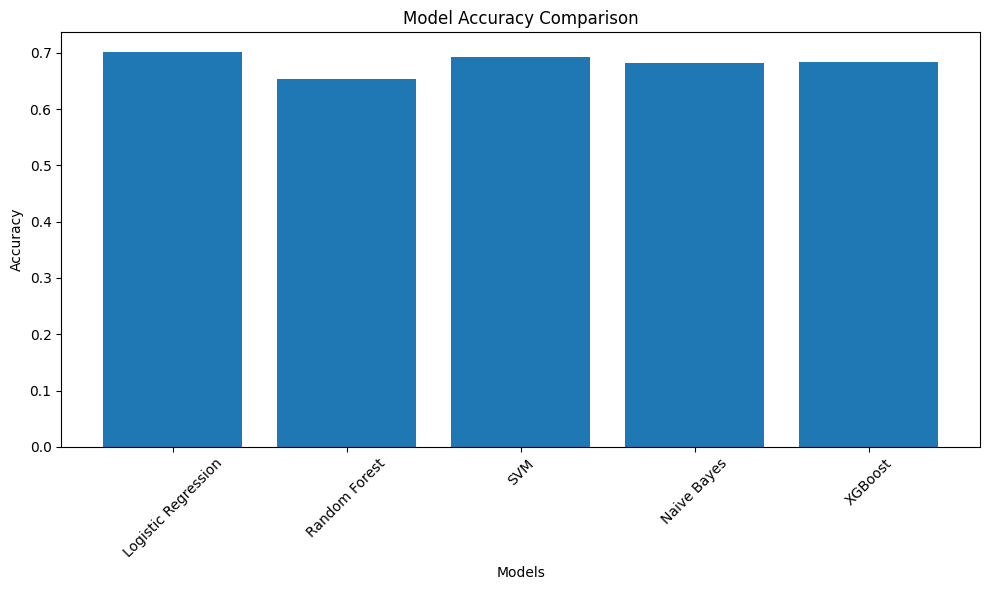


Best performing model: Logistic Regression
Accuracy: 0.7015


In [34]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], 
    df['sentiment_encoded'],  # Use encoded labels instead of original sentiment
    test_size=0.2, 
    random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize models with proper configurations
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    'SVM': SVC(
        kernel='linear',
        random_state=42,
        probability=True,
        decision_function_shape='ovr'
    ),
    'Naive Bayes': MultinomialNB(
        alpha=1.0
    ),
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        objective='multi:softprob',
        num_class=len(label_encoder.classes_),
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        
        # Train the model
        if name == 'XGBoost':
            model.fit(X_train_tfidf.toarray(), y_train)
        else:
            model.fit(X_train_tfidf, y_train)
        
        # Make predictions
        if name == 'XGBoost':
            y_pred = model.predict(X_test_tfidf.toarray())
        else:
            y_pred = model.predict(X_test_tfidf)
        
        # Convert numeric predictions back to original labels for reporting
        y_test_original = label_encoder.inverse_transform(y_test)
        y_pred_original = label_encoder.inverse_transform(y_pred)
        
        # Store results
        results[name] = {
            'accuracy': accuracy_score(y_test_original, y_pred_original),
            'classification_report': classification_report(y_test_original, y_pred_original),
            'confusion_matrix': confusion_matrix(y_test_original, y_pred_original)
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Accuracy: {results[name]['accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])
        print("\nConfusion Matrix:")
        print(results[name]['confusion_matrix'])
    
    except Exception as e:
        print(f"\nError training {name}:")
        print(str(e))
        continue

# Create a bar plot comparing accuracies for successful models
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in results.keys()]
successful_models = list(results.keys())
plt.bar(successful_models, accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Find the best performing model among successful ones
if results:
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    print(f"\nBest performing model: {best_model_name}")
    print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
else:
    print("\nNo models were successfully trained")

## Hyperparameter Optimization
We will perform hyperparameter optimization on the best performing model using GridSearchCV.

Performing GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gorkemozkan\Desktop\gorkDrive\finnews-insights\env\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\


Best parameters found:
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}

Best cross-validation accuracy: 0.6827

Optimized Model Performance on Test Set:
Accuracy: 0.6997

Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.21      0.31       169
           2       0.69      0.90      0.78       648
           3       0.76      0.57      0.65       352

    accuracy                           0.70      1169
   macro avg       0.67      0.56      0.58      1169
weighted avg       0.69      0.70      0.67      1169



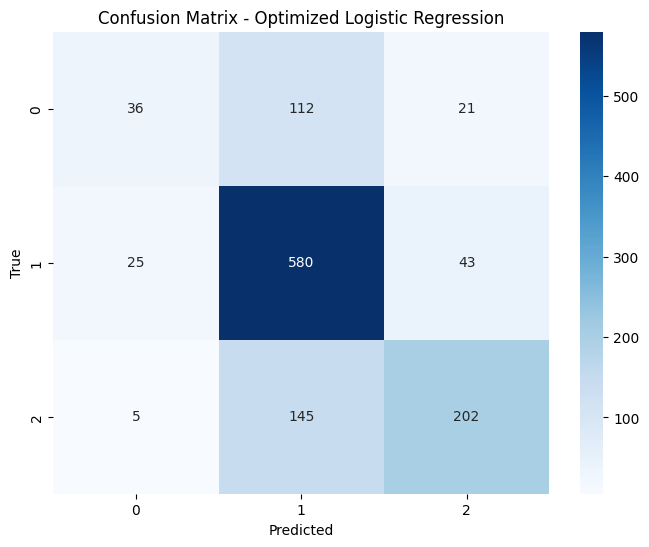

In [35]:
# Define parameter grid for each model type
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0],
        'fit_prior': [True, False]
    },
    'XGBoost': {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0]
    }
}

# Get the best model and its parameter grid
best_model = models[best_model_name]
best_model_params = param_grids[best_model_name]

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=best_model_params,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit GridSearchCV
print(f"Performing GridSearchCV for {best_model_name}...")
grid_search.fit(X_train_tfidf, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

print("\nOptimized Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Optimized {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model Testing
Let's test the model on new texts.

In [37]:
# Function for predicting sentiment of new texts
def predict_sentiment(text):
    # Preprocess text
    processed = preprocess_text(text)
    # TF-IDF transformation
    text_tfidf = tfidf.transform([processed])
    # Prediction (get numeric prediction)
    prediction_encoded = model.predict(text_tfidf)[0]
    # Convert back to original label
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    return prediction

In [38]:
# Test examples
test_texts = [
    "Stock market reaches all-time high as tech sector booms",
    "Company announces massive layoffs amid financial troubles",
    "Market remains stable as Fed maintains current interest rates"
]

# Make predictions on test examples
print("Test Results:")
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}")

Test Results:

Text: Stock market reaches all-time high as tech sector booms
Predicted sentiment: negative

Text: Company announces massive layoffs amid financial troubles
Predicted sentiment: negative

Text: Market remains stable as Fed maintains current interest rates
Predicted sentiment: negative
